In [6]:
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display
#import getFIRFFT as fir
from scipy import signal

In [7]:
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size
cmap_plot = plt.cm.bone_r  # default colormap for spectrogram, gray, reversed
# 오디오 파일 부르기
wavefile = 'D:/YYN/audio_/digitrec_ye/segmented/YouYeNa/3/kdigits0-3.wav'
x , sr = librosa.load(wavefile , sr=16000)
Ns = int(sr*Ts)  # 10ms 샘플 수
Nf = int(sr*Tf)  # 20ms 샘플 수

In [8]:
def getFIRFFT(H, order):
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT//2)
    order = min(order, NFFT-1)
    h = np.concatenate((h[len(h)-order//2:], h[0:order//2-1]))
    win = librosa.filters.get_window('hamming', len(h), fftbins=False)
    h = h*win
    return h.real

def drawFIRFFT(h, NFFT):
    plt.subplot(1,2,1)
    plt.plot(h)
    h_fft = np.abs(np.fft.fft(h, NFFT))
    plt.subplot(1,2,2)
    plt.plot(h_fft)
    plt.show()
    return h

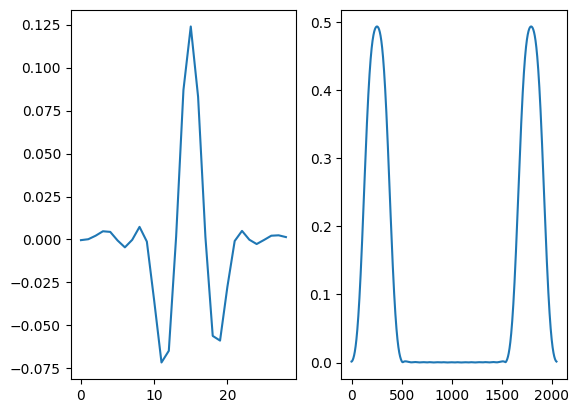

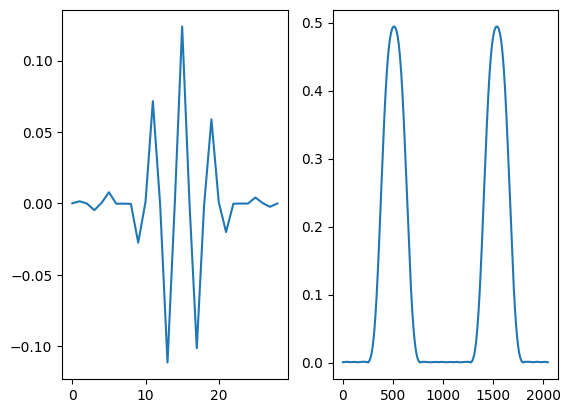

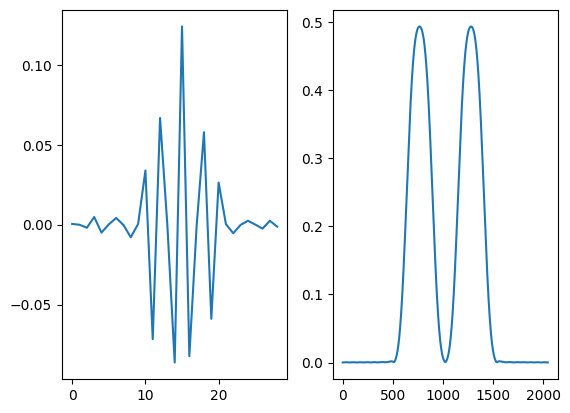

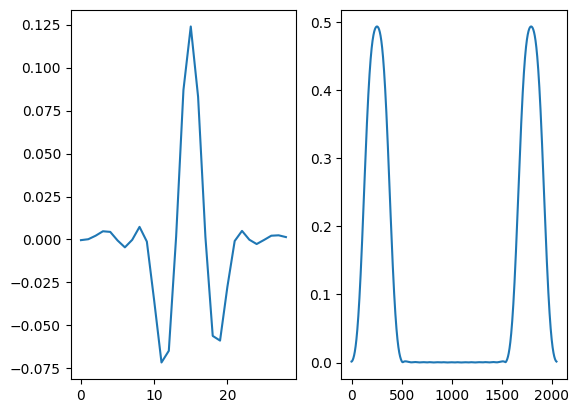

In [10]:
# 1.1khz lowpass filter
n = int(sr/1100)
H = np.array(([1.0]*n) + ([0.0]*int(Nf-2*n)) +([1.0]*n))   # 101 길이의 0-pi
NFFT = 2048
FIG_SIZE = (8,3)

order = 30
h_a = []
bandwidth = 1000
for i in [1000,2000,3000,1000]:
    n1 = int(((i - bandwidth//2) / (sr/2)) * (Nf+1))
    n1 = max(0, n1)
    n2 = int(((i + bandwidth//2) / (sr/2)) * (Nf+1))
    n2 = min(Nf, n2)
    H = np.zeros(int(Nf))
    H[n1:n2] = 1.0
    h = getFIRFFT(H, order)
    h_a.append(h)
    drawFIRFFT(h, 2048)


In [11]:
# memory samples
order = len(h_a[0])-1
xmem = np.zeros(order)
# overlap 3ms
Tov = 0.003  # 3ms
Nov = int(sr*Tov)
xoverlap = np.zeros(Nov)


In [13]:
y4 = np.zeros(len(x)+Nov)   # delay T_overlap (N_overlap)
yt = np.zeros(int(Ns+Nov))
RightWinOverlap = np.linspace(1,0,Nov+2)[1:-1]
LeftWinOverlap = np.linspace(0,1,Nov+2)[1:-1]
for n in range(len(h_a)):
    y4[(n * Ns):(n * Ns + Nov)] = yt[Ns:] * RightWinOverlap
    x1 = x[(n * Ns):((n + 1) * Ns)]
    x1 = np.concatenate((xmem, xoverlap, x1))
    yt[:] = signal.lfilter(h_a[n], [1], x1)[order:(order + Nov + Ns)]
    y4[(n * Ns):(n * Ns + Nov)] += yt[:Nov] * LeftWinOverlap
    y4[(n * Ns + Nov):((n + 1) * Ns)] = yt[Nov:Ns]
    xmem[:] = x1[Ns:(order + Ns)]
    xoverlap[:] = x1[(order + Ns):(order + Nov + Ns)]

   # y4[(len(h_a) * Ns):] = yt[Ns:]

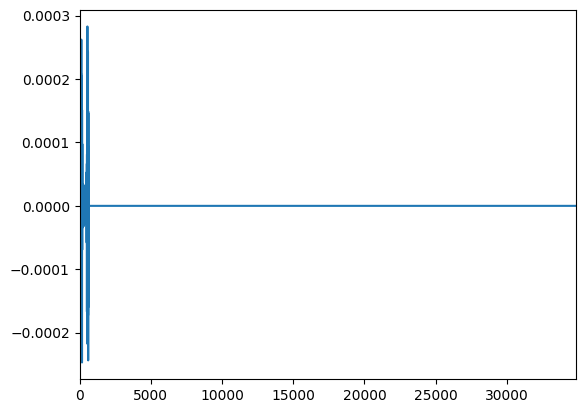

In [14]:
plt.figure()
plt.plot(y4)
plt.xlim([0, len(y4)])
plt.show()
